In [1]:
import pandas as pd
import nltk
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from collections import Counter
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.metrics.distance import jaccard_distance
from nltk.tokenize import sent_tokenize , word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# Functions Needed

In [2]:
def ScrFileProcessor (InpuSrcStr):
	OutSrcList=[]
	for SrcFile in InpuSrcStr.split(';'):
		if "lhsj_main/" in SrcFile:
			OutSrcList.append(SrcFile)
	if len(OutSrcList) != 0:
		OutSrcListStr=';'.join(sorted(OutSrcList))
	else:
		OutSrcListStr = ''
	return OutSrcListStr

In [3]:
def basicHistograms(df):

    #plotModuleCount = False
    #plotSourceCount = False

    #if (plotModuleCount):
    mainmodulecounts = Counter(df.Module)
    data = pd.DataFrame.from_dict(mainmodulecounts, orient='index')
    ax = data.plot(kind='bar',fontsize=6)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),rotation='horizontal',fontsize=6,transform=ax.transAxes)
    plt.show()

    #if (plotSourceCount):
#     uniquemodules = df.Module.unique()
#     df.groupby(["Module","Source Files"])

#     mainmodulecounts = Counter(df["Source Files"])
#     data = pd.DataFrame.from_dict(mainmodulecounts, orient='index')
#     ax = data.plot(kind='bar',fontsize=6)
#     for p in ax.patches:
#         ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),rotation='horizontal',fontsize=6,transform=ax.transAxes)
#     plt.show()

In [4]:
def lemmatization(X):
    #lemmatization function, received a dataFrame, finds lemmatized text for each line of the dataFrame
    # and returns a new dataFrame with lemmatized values
    #print("Observation column (before lemmatization) shape", X.shape)
    #rowCount=X.shape[0]
    customizedStopWords=['and\'', 'is\'', 'the\'', 'The\'','for\'','with\'', '_x000']
    
    lemmatizedX = np.empty([len(X)], dtype=object) 
    #just to test:
    #print("lemmatizedX shape",lemmatizedX.shape)
    wordnet_lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    separator=' '
    processedText=''
    for i in range(0,len(X)):
        t = X[i]
        processedText=''
        #building the sets
        list_d1 = []  
        s1 = sent_tokenize(t)
        for s in s1:
            w1 = word_tokenize(s)
            for w in w1:
                if(len(w) > 1 and w.isalpha() and w.lower not in stop_words ):
                    lem1 = wordnet_lemmatizer.lemmatize(w)
                    list_d1.append(lem1)
        processedText=separator.join(list_d1)
        lemmatizedX[i]=processedText
    #just to test:
    # print("unlemmatized entry",X[2])
    # print("lemmatized entry",lemmatizedX[2])
    #print("lemmatized Observation column shape", lemmatizedX.shape)
    return lemmatizedX

In [5]:
def calculateJaccardDistance(X):
    #Calculate Jaccard distance of Obsevation Column
    #row, column=X.shape
    row=column=X.shape[0]
    print("In calculateJaccardDistance Function, row & column:", row , column)
    #for jaccardDistance, we need set of words in each entry of X, not just lemmatized text
    text_sets=[]
    for i in range(0, len(X)):
        list_d=[]
        w1=word_tokenize(X[i])
        for w in w1:
            list_d.append(w)
        text_sets.append(set(list_d))
    
    #text_sets=lemmatization(X["Observation.Observation"])
    #Find min and max distance as well.
    maxd = 0
    mind = 1
    mini = -1
    minj = -1
    maxi = -1
    maxj = -1

    #Calculate Jaccard distance for all tokenized and lemmatized words. Jaccard distance between each entry of "Obsevation" Column. 
    dist = np.empty(shape=(len(text_sets),len(text_sets)))# Matrix is initialized with float zeros.
    #Print just to test data
    print("5 rows and columns from the initial matrix:\n")
    print(dist[0:5,0:5])

    for i in range(len(text_sets)-1):
        for j in range(i+1,len(text_sets)): 
            dist[i,j] = jaccard_distance(text_sets[i],text_sets[j])
            dist[j,i] = jaccard_distance(text_sets[i],text_sets[j])
            if(dist[i,j] > maxd):
                maxd = dist[i,j]
                maxi = i
                maxj = j
            if(dist[i,j] < mind):
                mind = dist[i,j]
                mini = i
                minj = j
    #Print just to test data 
    print("print 5 rows and columns from the matrix:\n")     
    print(dist[0:5,0:5])
    print("closest entries are dist[i,j] for i , j " , mind ,mini, minj)
    print("most different entries are d[i,j] for i, j" , maxd , maxi , maxj)
    return dist

In [6]:
def modelSelection():
    models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
              LinearSVC(),
              MultinomialNB(),
              LogisticRegression(random_state=0),]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

    import seaborn as sns

    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    cv_df.groupby('model_name').accuracy.mean()

In [8]:
# def featureEngineering(X):
#     # Generate wordcloud image before lemmatization
#     allwords = WordCloud(stopwords=STOPWORDS).generate(str(X["Observation"].values))
#     plt.imshow(allwords, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

#     # For visualization only, as calculateJaccardDistance does lemmatization as well.
#     if (False):
#         start = datetime.now()
#         text_sets=lemmatization(X["Observation"])
#         end = datetime.now()
#         print("Lemmatization took: ", (end-start))

#         #Generate wordcloud image after lemmatization:
#         allwords = WordCloud(stopwords=STOPWORDS).generate(str(text_sets))
#         plt.imshow(allwords, interpolation="bilinear")
#         plt.axis("off")
#         plt.show()
    
#     #Calculate Jaccard distance
#     start = datetime.now()
#     jDistance = calculateJaccardDistance(X)
#     end = datetime.now()

In [7]:
def calculateAccuracyEachClass(test,pred):
    conf_mat = confusion_matrix(test, pred)
    accuracy = conf_mat.diagonal()/conf_mat.sum(axis=1)
    length = len(accuracy)
    x = module_id_df.Module[:length]
    frame = pd.DataFrame(accuracy, columns=['Accuracy'], index=x)
    pd.set_option('display.max_rows', None)
    display(frame)
    frame.plot(kind='bar',fontsize=6)
    plt.show()

In [8]:
'''
 The purpose of this class is to add a custom transform stage to the Pipeline.
 If the sample passes to the pipeline is multidimensional (or a pandas data frame)
 and we want to operate only on a subset of the features, the constructor has to
 receive the name(s) of the features passed through the constructor.  This is used
 as the index in the transform function
'''
class CustomTransformer(BaseEstimator, TransformerMixin):
    # Lifted from this article: https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156
    def __init__(self, feature_name):
        print('>>>>>>>init() called')
        self.feature_name = feature_name

    def fit(self, X, y = None):
        print('>>>>>>>fit() called.')
        return self

    def transform(self, X, y = None):
        print('>>>>>>>transform() called.')
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        #X_[self.feature_name] = dosomething(X_[self.feature_name])
        return X_

In [9]:
class RandomPicker(CustomTransformer):
    def __init__(self):
        np.random.seed(0)

    def fit(self,X, y=None):
        # This makes sure that the random number distribution follows the label distribution in the training set
        self.labels = np.random.permutation(y)

    def predict(self,X):
        return self.labels[:X.shape[0]]

In [10]:
def compute_tfidf(corpus, ngram_range=(1, 1), max_features=None):
    """ Calculate the tfidf features for all the text documents and return a (documents, fatures) matrix. """
    vectorizer = TfidfVectorizer(input='content', ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
    print('Computing tfidf features...', end='')
    X = vectorizer.fit_transform(corpus)
    print('done!')
    return X, vectorizer

In [12]:
def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    return label_encoder

In [13]:
def crossValidation(model,feature,label):
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    accs = []
    reports = []
    f1_scores = []
    st_time = time.time()
    for train_index, test_index in skfold.split(feature,label):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state = 42)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_pred, y_test)
        accs.append(accuracy)
        metrics_report = classification_report(y_test, y_pred, labels=keyword_list, target_names=keyword_list)
        reports.append(metrics_report)

    en_time = time.time()
    print('Total time: {:.2f}s'.format(en_time-st_time))   
    print('mean accuracy: {:.2f}'.format(np.mean(accs)))

# Data Cleanup

In [14]:
df=pd.read_excel("search-2019-09-13(9578)-DATA SET.xlsx").fillna("")
#EVAHFAR: move the renaming to here from after clean up.
df.rename(columns = {'Observation.Observation':'Observation','Main Module':'Module','Source Files':'SrcFile','General.Eriref':'TRRef'}, inplace = True)

#EVAHFAR: I have extracted 0.15% to dfHold
#EVAHFAR: I have extracted rest 85% to df
#the previous code what ever odes in df, does not need to be changed.
#EVAHFAR: Normal (hold extracted version of df, after clean up) stays with same name as df, so no need to change anything in code.
# EVAHFAR: the hold dataframe after clean up has dfHold name to be fed into tunned and tested moidel.

##### Hold Extraction Start ########
# Hold outputs are : df (85% of df) and dfHold (15% of df)
labelClass=['Module', 'SrcFile']
labelObsv=['Observation','TRRef']
X_Model, X_Hold, y_Model, y_Hold = train_test_split(df[labelObsv], df[labelClass], test_size = 0.15)
df.drop(df.index, inplace=True)
df=y_Model
df[labelObsv]=X_Model[labelObsv]
dfHold=y_Hold
dfHold[labelObsv]=X_Hold[labelObsv]
##### Hold Extraction END ########

##### CleanUp Started on df : cleaned output will be df ########
df.loc[df['Module']==';', 'Module']=""
df.loc[df['SrcFile']==';', 'SrcFile']=""
df['SrcFile']=df['SrcFile'].apply(ScrFileProcessor)
df=df.loc[df['Observation']!='Error: Data too large for Excel cell']
df=df.groupby(['TRRef', 'Observation', 'Module','SrcFile']).size().reset_index(name='count').drop('count', axis=1)
df=df.loc[df['Module']=='kw'].head(30).append(df.loc[df['Module']!='kw'])
df=df.loc[df['Module']!='']
df['ModSrc']=df['Module']+'#'+df['SrcFile']
##### Clean Up Ended on df ########

##### CleanUp Started on dfHold : cleaned output will be dfHold ########
dfHold.loc[dfHold['Module']==';', 'Module']=""
dfHold.loc[dfHold['SrcFile']==';', 'SrcFile']=""
dfHold['SrcFile']=dfHold['SrcFile'].apply(ScrFileProcessor)
dfHold=dfHold.loc[dfHold['Observation']!='Error: Data too large for Excel cell']
dfHold=dfHold.groupby(['TRRef', 'Observation', 'Module','SrcFile']).size().reset_index(name='count').drop('count', axis=1)
dfHold=dfHold.loc[dfHold['Module']=='kw'].head(30).append(dfHold.loc[dfHold['Module']!='kw'])
dfHold=dfHold.loc[dfHold['Module']!='']
dfHold['ModSrc']=dfHold['Module']+'#'+dfHold['SrcFile']
##### Clean Up Ended on dfHold ########

dfHold.index = range(len(dfHold.index))

# Renaming 'Observation.Observation' to 'Observation' and 'Main Module' to 'Module' for simplification
# Moved this from here to begining of the code before clean up. Please remove all these lines if agree.
#df.rename(columns = {'Observation.Observation':'Observation','Main Module':'Module'}, inplace = True)

# Applying proper indices
#EVAHFAR: made the lenght dynamic, to not have hardcoded values.
df.index = range(len(df.index))

# list of all the modules !!!be auto
# EVAHFAR: Made list dynamic to cover all keywords
# EVAHFAR: Original line was: keyword_list = ['cms', 'cx', 'dab', 'bch', 'servlib', 'fms', 'pms', 'ax', 'gmd', 'mih', 'func_frmwk_srv', 'suf', 'account', 'Px', 'wms', 'DocGenLib', 'wab', 'func_frmwk_clt', 'wmx', 'admx', 'rlh', 'dch', 'common', 'kw', 'bgh', 'mx', 'mla', 'lacalib', 'billsrv', 'bat', 'Ei', 'data', 'fuomlib', 'rih', 'dcx', 'wsi', 'Rd', 'rp', 'as', 'Ra', 'tax', 'fih', 'dcs', 'utility', 'udrlib', 'wma', 'teh', 'dxlib', 'urh', 'pih', 'pth', 'ceb', 'foh', 'cerm', 'secServer', 'func_frmwk_cmn', 'java.x', 'cah', 'func_util', 'bee', 'jcil', 'judrlib', 'Ta', 'esh', 'uch_k', 'omx', 'opSupport', 'BAggLib', 'XMLRPCSimulator', 'Gl', 'bjx', 'ioh', 'taplib', 'oms', 'cs_rer', 'pbm', 'pwdmgr', 'ppth', 'auth', 'rhel72_x86.x', 'prepare_bscs_server.sh', 'birdlib', 'licadp', 'scheduler', 'cdh', 'cab', 'csadapters', 'remote', 'udrag', 'rch', 'license', 'jdxlib', 'gdh', 'vmdrep', 'pbs', 'rhel65_x86.x', 'aih', 'adp600', 'rulelib', 'include', 'docgen', 'bumt', 'udmaplib']
keyword_list = sorted(list(dict.fromkeys(df['Module'].tolist())))

# Adding a column to encode the Main Module as an integer because categorical variables are often better represented by integers than strings.
# We also create a couple of dictionaries for future use.
df['module_id'] = df['Module'].factorize()[0]
module_id_df = df[['Module', 'module_id']].drop_duplicates().sort_values('module_id')
module_to_id = dict(module_id_df.values)
id_module_df = df[['module_id', 'Module']]
id_to_module = dict(id_module_df.values)
pd.options.display.max_rows
display(dfHold)

,TRRef,Observation,Module,SrcFile,ModSrc
0,HP90064,EFFECT:\nPAM class not changed (and inconsiste...,kw,,kw#
1,HQ34493,EFFECT:\r\nAF recovery job for subscriber havi...,kw,,kw#
2,HQ37628,EFFECT:\r\nCannot use PAM Special Service.\r\n...,kw,,kw#
3,HQ75058,"Test Envirnment : Test Plan 1 , CBIO 1\nTest d...",kw,,kw#
4,HQ77676,EFFECT:\n\n\n\nDESCRIPTION:\nIn Test plant 2:\...,kw,,kw#
...,...,...,...,...,...
672,HX86929,ETI180 Add Service with backdate resulting in ...,cms,lhsj_main/bscs/cms/src/cms/java/com/lhs/Contra...,cms#lhsj_main/bscs/cms/src/cms/java/com/lhs/Co...
673,HX87158,SLOGAN:- Payment entered DCH_EVENT_CTRL in wro...,fms,lhsj_main/bscs/cms/src/fms/java/com/lhs/fm/all...,fms#lhsj_main/bscs/cms/src/fms/java/com/lhs/fm...
674,HX87204,1 EFFECT\nCAH with option -a4 is not cleaning ...,cah,lhsj_main/bscs/batch/src/cah/cah.c,cah#lhsj_main/bscs/batch/src/cah/cah.c
675,HX87501,1 EFFECT\n1.1 Trouble summary\nUnnecessary Sum...,servlib,lhsj_main/bscs/batch/src/servlib/ServiceProrat...,servlib#lhsj_main/bscs/batch/src/servlib/Servi...


# Data Visualization after clean up

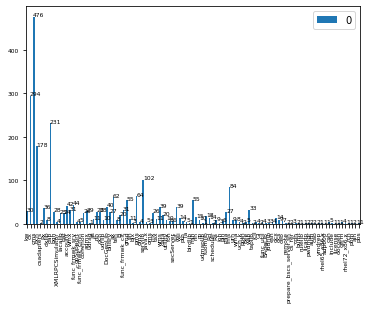

In [15]:
basicHistograms(df)
#display(df)

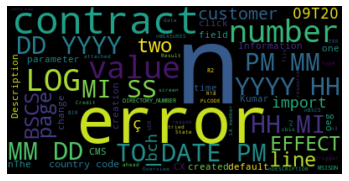

In [16]:
# Generate wordcloud image before lemmatization
allwords = WordCloud(stopwords=STOPWORDS).generate(str(df["Observation"].values))
plt.imshow(allwords, interpolation="bilinear")
plt.axis("off")
plt.show()

# Applying Lemmetization to Observation column

Lemmatization took:  0:00:11.603357


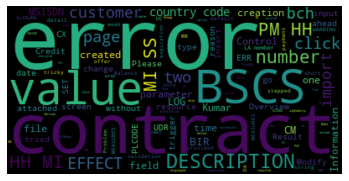

In [17]:
# Applying lemmetization on the Observation column
start = datetime.now()
text_sets=lemmatization(df["Observation"])
df["Observation"] = text_sets
end = datetime.now()
print("Lemmatization took: ", (end-start))

#Generate wordcloud image after lemmatization:
allwords = WordCloud(stopwords=STOPWORDS).generate(str(text_sets))
plt.imshow(allwords, interpolation="bilinear")
plt.axis("off")
plt.show()
#display(df)

# Text Representation

In [18]:
ngram_range   = (1, 1)
max_features  = None
X, vectorizer = compute_tfidf(df['Observation'], ngram_range, max_features)
labels = df.Module.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(df.Module)
print(X.shape)
print(y.shape)
#display(df)

Computing tfidf features...done!
(2611, 3914)
(2611,)


# Model Selection

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


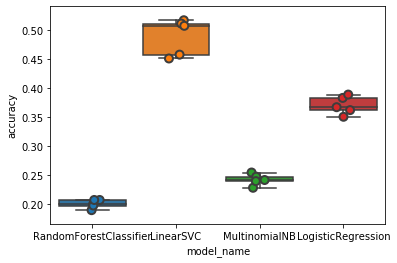

In [19]:
modelSelection()

# Split the Dataset into Train and Test Sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 42)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (1827, 3914)  | Test set Shape: (784, 3914)


# Random Picker

accuracy 0.08545918367346939


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Accuracy
Module,
kw,NaN
cx,0.000000
cms,0.000000
bch,0.000000
csadapters,NaN
Px,0.000000
dxlib,0.000000
dab,NaN
bgh,0.000000


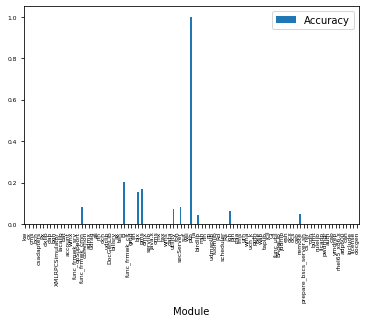

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

rp = Pipeline([('randompicker', RandomPicker())])
rp.fit(X_train, y_train)

y_pred = rp.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
calculateAccuracyEachClass(y_test,y_pred)

## Multi-Class Classifier: TF-IDF and Naive Bayes

In [22]:
# ###### Train Test Split Started ###########
# ##### Model Optimization needs to be done by 'Main Module' on Train Set ----- (X_Train, y_trainTune)
# ##### Tuned Model needs to be fit by 'ModSrc' on TrainSet  --------- (X_Train, y_trainFit)
# ##### Fitted Model above needs to be used on Test Set over 'ModSrc'  -------  (X_Test, y_Test)
# ##### All performance measurements needs to be done over Test set using 'ModSrc'
# label=['Module', 'ModSrc']
# X_trn, X_tes, y_trn, y_tes = train_test_split(df['Observation'], df[label], test_size = 0.3)

# print("train", X_trn.shape, y_trn.shape)
# print("test", X_tes.shape, y_tes.shape)
# X_Train=X_trn
# y_trainTune=y_trn['Module']
# y_trainFit=y_trn['ModSrc']
# X_Test=X_tes
# y_Test=y_tes['ModSrc']

# print("train", X_Train.shape, y_trainTune.shape, y_trainFit.shape)
# print("test", X_Test.shape, y_Test.shape)
# ###### Train Test Split Done ###########

>>>>>>>init() called
>>>>>>>fit() called.
>>>>>>>transform() called.
>>>>>>>transform() called.
accuracy 0.25892857142857145


,Accuracy
Module,
kw,0.000000
cx,0.000000
cms,0.000000
bch,0.000000
csadapters,0.000000
Px,0.000000
dxlib,0.000000
dab,0.000000
bgh,0.000000


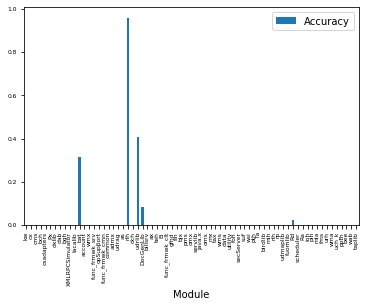

Total time: 0.20s
mean accuracy: 0.22


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due

In [34]:
# X_train, X_test, y_train, y_test = train_test_split(df['Observation'], df['Module'], random_state = 0)
nb_model = MultinomialNB()
nb = Pipeline([('custom', CustomTransformer(feature_name="See the class description for details")),
              ('clf', nb_model),
              ])

nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred, labels=keyword_list, target_names=keyword_list))
calculateAccuracyEachClass(y_test,y_pred)
crossValidation(nb_model,X,y)

## LinearSVC

(784,) (784,)
accuracy 0.5357142857142857


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Accuracy
Module,
kw,0.300000
cx,0.500000
cms,0.818182
bch,NaN
csadapters,0.000000
Px,0.000000
dxlib,0.466667
dab,0.555556
bgh,NaN


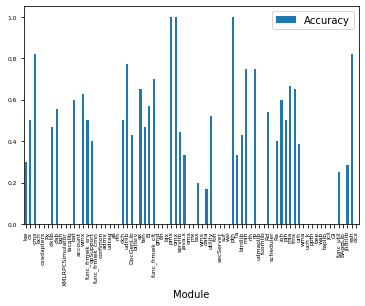

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due

Total time: 1.68s
mean accuracy: 0.48


In [24]:
SVC_model = LinearSVC()
SVC_model.fit(X_train, y_train)
y_pred = SVC_model.predict(X_test)
print(y_pred.shape, y_test.shape)
from sklearn import metrics
print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(metrics.classification_report(test_y, y_pred, labels=keyword_list, target_names=df['Module'].unique()))
calculateAccuracyEachClass(y_test,y_pred)
crossValidation(SVC_model,X,y)

In [25]:
# from IPython.display import display
# col = ['Module', 'Observation']
# col
# for predicted in module_id_df.module_id[:86]:
#     for actual in module_id_df.module_id[:86]:
#         if predicted != actual and conf_mat[actual, predicted] >= 2:
#             print("'{}' predicted as '{}' : {} examples.".format(id_to_module[actual], id_to_module[predicted],
#                                                                 conf_mat[actual,predicted]))
#             #display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Module', 'Observation']])
#             print('')

## Linear Support Vector Machine

>>>>>>>init() called
>>>>>>>fit() called.
>>>>>>>transform() called.
>>>>>>>transform() called.
accuracy 0.5204081632653061


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Accuracy
Module,
kw,0.200000
cx,0.500000
cms,0.818182
bch,NaN
csadapters,0.000000
Px,0.000000
dxlib,NaN
dab,0.400000
bgh,0.444444


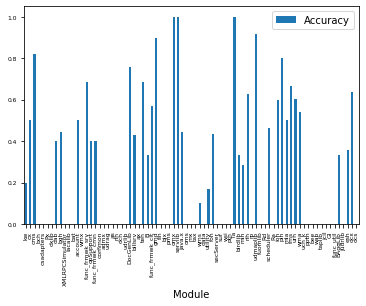

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due

Total time: 0.82s
mean accuracy: 0.48


In [26]:
sgd_model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5,tol=None)
sgd = Pipeline([('custom', CustomTransformer(feature_name="See the class description for details")),
              ('clf', sgd_model),
              ])

sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred, labels=keyword_list, target_names=keyword_list))
calculateAccuracyEachClass(y_test,y_pred)
crossValidation(sgd_model,X,y)

## Logistic Regression

>>>>>>>init() called
>>>>>>>fit() called.
>>>>>>>transform() called.
>>>>>>>transform() called.
accuracy 0.20535714285714285


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Accuracy
Module,
kw,0.000000
cx,0.000000
cms,0.000000
bch,0.000000
csadapters,0.000000
Px,0.000000
dxlib,0.000000
dab,0.000000
bgh,0.000000


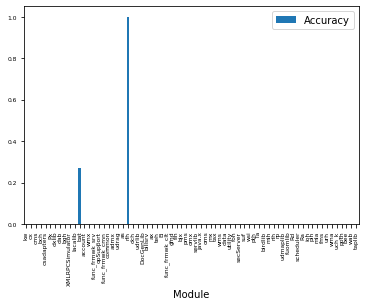

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

Total time: 5.78s
mean accuracy: 0.18


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in

In [28]:
logreg_model = LogisticRegression(n_jobs=1, C=1e5, max_iter = 5)
logreg = Pipeline([('custom', CustomTransformer(feature_name="See the class description for details")),
              ('clf', logreg_model),
              ])
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred, labels=keyword_list, target_names=keyword_list))
calculateAccuracyEachClass(y_test,y_pred)
#display(df)
crossValidation(logreg_model,X,y)

## KNeighbors Classifier

In calculateJaccardDistance Function, row & column: 2611 2611
5 rows and columns from the initial matrix:

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
print 5 rows and columns from the matrix:

[[0.         0.92125984 0.87288136 0.87188612 0.89051095]
 [0.92125984 0.         0.92727273 0.91756272 0.87704918]
 [0.87288136 0.92727273 0.         0.93950178 0.936     ]
 [0.87188612 0.91756272 0.93950178 0.         0.90311419]
 [0.89051095 0.87704918 0.936      0.90311419 0.        ]]
closest entries are dist[i,j] for i , j  0.0 208 209
most different entries are d[i,j] for i, j 1.0 0 2237
accuracy 0.18097447795823665
                        precision    recall  f1-score   support

                    kw       0.00      0.00      0.00         0
                    cx       0.00      0.00      0.00        19
                   cms       0.00      0.00      0.00         8
                   bch       0.00      0.00      0.00         1
           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy
Module,
kw,0.000000
cx,0.000000
cms,0.000000
bch,0.000000
csadapters,0.000000
Px,0.000000
dxlib,0.000000
dab,0.000000
bgh,0.000000


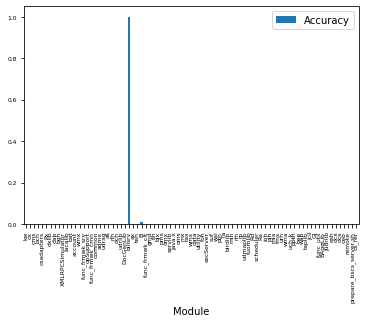

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due

Total time: 0.56s
mean accuracy: 0.35


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: Und

In [29]:
#display(df)
features = calculateJaccardDistance(df["Observation"])
labels = df["Module"]

train_X, test_X, train_y, test_y, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
knn_model = KNeighborsClassifier(n_neighbors=1)
knn = Pipeline([("classification",nb_model)])
knn.fit(train_X, train_y)

y_pred = knn.predict(test_X)
 
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred, labels=keyword_list, target_names=df['Module'].unique()))

calculateAccuracyEachClass(test_y,y_pred)
crossValidation(knn_model,features,labels)

In [32]:
# conf_mat = confusion_matrix(y_pred, test_y)
 
# pyplot.figure(figsize=(8,8))
# pyplot.clf()
# sns.set()
# sns.heatmap(conf_mat.T,square=True,annot=False,xticklabels=module_id_df.Module.values,yticklabels=module_id_df.Module.values,cbar=True,vmin=0, vmax=np.max(conf_mat),cmap='Blues',fmt="d")
# pyplot.xlabel("True Label")
# pyplot.ylabel("Predicted Label")
# pyplot.title(type, pad='25')
# pyplot.tight_layout()
# pyplot.show()

In [35]:
data = np.array([['Model' , 'TrainScore', 'TestScore'],
               ['SVM', sgd_model.score(X_train,y_train),sgd_model.score(X_test,y_test)],
               ['MultinomialNB',nb_model.score(X_train,y_train), nb_model.score(X_test,y_test) ],
               ['KNN', knn_model.score(X_train,y_train), knn_model.score(X_test,y_test)],
               ['LogisticRegression', logreg_model.score(X_train,y_train),logreg_model.score(X_test,y_test)],
               ['LinearSVC', SVC_model.score(X_train,y_train), SVC_model.score(X_test,y_test)]])
pd.DataFrame(data[1:, :], columns=data[0,:])

,Model,TrainScore,TestScore
0,SVM,0.7372742200328407,0.7397959183673469
1,MultinomialNB,0.2348111658456486,0.25255102040816324
2,KNN,0.7219485495347564,0.7079081632653061
3,LogisticRegression,0.17898193760262726,0.18877551020408162
4,LinearSVC,0.7624521072796935,0.7627551020408163


# Prediction using LinearSVC model

In [39]:
data = dfHold
X = data['Observation'] # Collection of documents
y = data['Module']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC()
model.fit(tfidf_vectorizer_vectors, y_train)
X.index = range(len(X.index))
lst = [X]
series = pd.Series(X)
prediction = (model.predict(fitted_vectorizer.transform(lst[0])))
series_1 = pd.Series(prediction)
dataFrame = {"Observation":series,
    "PredictedModule":series_1}
predictedDf = pd.concat(dataFrame,axis=1) 
predictedDf['Module'] = dfHold['Module']
predictedDf['Matching'] = np.where(predictedDf['PredictedModule'] == dfHold['Module'], True, False)
display(predictedDf)
predictedDf.Matching.value_counts()

y_pred = model.predict(X_test)
calculateAccuracyEachClass(y_test,y_pred)
crossValidation(knn_model,features,labels)

,Observation,PredictedModule,Module,Matching
0,EFFECT:\nPAM class not changed (and inconsiste...,kw,kw,True
1,EFFECT:\r\nAF recovery job for subscriber havi...,cms,kw,False
2,EFFECT:\r\nCannot use PAM Special Service.\r\n...,kw,kw,True
3,"Test Envirnment : Test Plan 1 , CBIO 1\nTest d...",kw,kw,True
4,EFFECT:\n\n\n\nDESCRIPTION:\nIn Test plant 2:\...,kw,kw,True
5,"EFFECT: \nOffer220, Usage, BIR processed corre...",kw,kw,True
6,PX: GIT_CBIO3.0_WOW01_130325\r\n\r\nIt seems ...,kw,kw,True
7,EFFECT:\n\nNot possible to access BSCS databas...,kw,kw,True
8,EFFECT:\nWrong Accumulated amount for DA of ty...,cx,kw,False
9,Test phase : Reference configuration \nLevel :...,kw,kw,True


ValueError: could not convert string to float: 'DCH stops and payment events are not sent to IX  and generated Core Dump.\n\n5PEyIDLzwVGBwTLwAoPBUcGhMqUX5tR09IECsAKDwVHBoSKwR7OhUaHxMjACg8FRwaECoAKDwVHBoQKwAoPBUcGhAqACg8FRwaECMFKjpDGkwXLwUoOEMYGxArACg8FRwaEC \n MAKDwVHBoQKgAoPBUcGhArASw8FRwaECsAKDwVHBoQKQAoPBUcGhAqACg8FRwaEisAKDwVHBoQKwAoPBQcGhAqACg8FRwaECkALTwUHBoQKgAoPBQcGhIrACg8FBwbECIAKD \n wVHBoQKgAoPBQcGxArACg8FRwaEi0AKDwVHBoQKQAoPBc= \n IOR:0000! \n 322e3136p \n afab \n 0000 \n 0000 \n 00080000p \n  \n 1012 \n not logged on \n TNS listener failed to start a dedicated server process \n utdoOracle is not available \n 1033 \n initialization or shutdown in progress \n n pr3113 \n 1034 \n Integer \n 1034 \n 1089 \n Integer \n 1089 \n immediate shutdown in progress \n nicanot connected to Oracle \n Integer \n 3113 \n end-of-file on communication channel \n 12153 \n 3114 \n Integer \n 3114 \n 3135 \n Integer \n 3135 \n connection lost contact \n Integer \n 12153 \n TNS unable to connect destination \n PROGRAM \n bscspapp01.digicelgroup.local \n to sinvalid username/password;logon denied \n 12500 \n Integer \n 12500 \n ches25402 \n OraErrorsToTerminate \n 25401 \n Integer \n 25401 \n can not continue fetches \n Integer \n 25402 \n must roll back \n n ki1017 \n 25405 \n Integer \n 25405 \n transaction status unkown \n 25408 \n Integer \n 25408 \n can not safely replay call \n Integer \n your session has been killed'